# NDVI Thresholds
*****
# Notebook Summary

* LANDSAT 7 is used to detect changes in plant life both over time and between a baseline period and a target acquisition.
* Very basic xarray manipulations are performed.
* The data is cleaned of clouds and scanlines - both with and without creating mosaics (composite images).

<hr>
# Notebook Index

* [Import dependencies and connect to the datacube](#import)
* [Choose platform and product](#plat_prod)
* [Get the maximum extents of the datacube](#extents)
* [Define extents you require that fall within the maximum extents](#define_extents) (selecting too much can make the acquisition process slow)
* [Understand filtering of cloud data and scan lines](#filter)
* [Examine cleaned, time-series data](#time_series)
  * [Retrieve the data from the datacube](#retrieve_data_time_series)
  * [Obtain the clean mask](#obtain_clean_mask_time_series)
  * [Filter out clouds and scan lines](#clean_mask_time_series)
  * [Calculate NDVI](#calculate)
  * [Examine true and false color maps](#true_false_maps)
  * [Plot a map of a specific acquisition NDVI using gradients](#plot_maps)
  * [Plot a time series analysis](#time_series_analysis)
* [Examine cleaned, mosaic data](#mosaic)
  * [Retrieve the data from the datacube](#retrieve_data_mosaic)
  * [Obtain the clean mask](#obtain_clean_mask_mosaic)
  * [Filter out clouds and scan lines, and create a mosaic](#clean_mask_mosaic)
  * [Select the target date and the dates you wish to form a baseline measure from](#baseline)
  * [Compare the target date's NDVI values against the baseline composite image](#compare)
  * [Plot the results](#plot)

<hr>
# How It Works

To detect changes in plant life, we use a measure called NDVI. 
* <font color=green>NDVI</font> is the ratio of the difference between amount of near infrared light <font color=red>(NIR)</font> and red light <font color=red>(RED)</font> divided by their sum.
<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>
<div class="alert-info">
The idea is to observe how much red light is being absorbed versus reflected. Photosynthetic plants absorb most of the visible spectrum's wavelengths when they are healthy.  When they aren't healthy, more of that light will get reflected.  This makes the difference between <font color=red>NIR</font> and <font color=red>RED</font> much smaller which will lower the <font color=green>NDVI</font>.  The resulting values from doing this over several pixels can be used to create visualizations for the changes in the amount of photosynthetic vegetation in large areas.
</div>

## <a id="import">Import Dependencies and Connect to the Data Cube</a>

In [1]:
%matplotlib inline

#Import the datacube and the API
import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi
from dc_notebook_utilities import generate_metadata_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

#Create an instance of the datacube and API
dc = datacube.Datacube(config="/home/localuser/.datacube.conf")
api = DataAccessApi(config="/home/localuser/.datacube.conf")

## <a id="plat_prod">Choose Platform and Product</a>

In [2]:
# Get available products
products = dc.list_products()

# Lst LANDSAT 7 products
print(products[["platform", "name"]][products.platform == "LANDSAT_7"])

     platform                           name
id                                          
8   LANDSAT_7       ls7_collections_sr_scene
70  LANDSAT_7  ls7_collections_sr_scene_lean
19  LANDSAT_7        ls7_ledaps_amazon_river
20  LANDSAT_7          ls7_ledaps_bangladesh
35  LANDSAT_7     ls7_ledaps_bangladesh_bari
36  LANDSAT_7             ls7_ledaps_caqueta
21  LANDSAT_7            ls7_ledaps_colombia
22  LANDSAT_7               ls7_ledaps_ghana
23  LANDSAT_7               ls7_ledaps_kenya
41  LANDSAT_7        ls7_ledaps_lake_baringo
24  LANDSAT_7      ls7_ledaps_lake_chad_full
25  LANDSAT_7        ls7_ledaps_lake_cortijo
26  LANDSAT_7      ls7_ledaps_menindee_lakes
27  LANDSAT_7          ls7_ledaps_meta_river
62  LANDSAT_7              ls7_ledaps_mexico
28  LANDSAT_7     ls7_ledaps_salgar_colombia
72  LANDSAT_7          ls7_ledaps_sanagustin
63  LANDSAT_7               ls7_ledaps_scene
29  LANDSAT_7                ls7_ledaps_togo
30  LANDSAT_7               ls7_ledaps_tonga
31  LANDSA

In [3]:
# These are the platform (satellite) and product (datacube set) 
# used for this demonstration.
platform = "LANDSAT_7"
product = "ls7_ledaps_kenya"

The magnitudes of the different wavelengths of light can be quanitized and stored on a per pixel basis.  <font color=green>NDVI</font> only requires the use of <font color=red>NIR</font> and <font color=red>RED</font> light but there are many more wavelengths and some additional measures available.  One such additional measure is called <font color=darkblue>pixel_qa</font>.  This is a measure of the quality of the pixel for analysis. A breakdown of the values stored in <font color=darkblue>pixel_qa</font> are beyond the scope of this notebook but we encourage you to check our github for more information on the meaning behind the values stored within.
![](diagrams/rainy_demo/ls7_xarray.png) 

## <a id="extents">Get the Extents of the Cube</a>

In [4]:
# Get the extents of the cube.
descriptor = api.get_query_metadata(platform=platform, product=product)

# Store the latitudinal and longitudinal extents.
lat, lon = products.resolution[products.platform == platform].any()

In [5]:
from utils.data_cube_utilities.dc_display_map import display_map

#save extents
min_date, max_date = descriptor['time_extents']
min_lat, max_lat = descriptor['lat_extents']
min_lon, max_lon = descriptor['lon_extents']

#Adjust date string
min_date_str = str(min_date.year) + '-' + str(min_date.month) + '-' + str(min_date.day)
max_date_str = str(max_date.year) + '-' + str(max_date.month) + '-' + str(max_date.day)

#Round GPS coordinates to 3 decimal places
min_lat_rounded = round(min_lat, 3)
min_lon_rounded =  round(min_lon, 3)
max_lat_rounded = round(max_lat, 3)
max_lon_rounded = round(max_lon, 3)

#display the total area available in this datacube product that can be used for analysis
display_map(latitude = (min_lat_rounded, max_lat_rounded),longitude = (min_lon_rounded, max_lon_rounded))

In [6]:
# Display metadata.
generate_metadata_report(min_date_str, max_date_str, 
                         min_lon_rounded, max_lon_rounded, lon,
                         min_lat_rounded, max_lat_rounded, lat)

,Min,Max,Resolution
Date:,2005-1-8,2016-12-24,
Longitude:,34.655,36.899,0.000269995
Latitude:,-0.942,0.95,-0.000271302


## <a id="define_extents">Define the Extents of the Analysis</a>

In [7]:
# Specify latitude and longitude bounds within the full extents 
# shown in the metadata report above (reduce area for faster processing times).
min_lon_small = 35.5
max_lon_small = 35.7
min_lat_small = 0.5
max_lat_small = 0.7
#display the subset for analysis.
display_map(latitude = (min_lat_small, max_lat_small),longitude = (min_lon_small, max_lon_small))

## <a id="filter">Filtering Clouds and Scan Lines</a>

#### Clouds:
Clouds can obscure imagery from satellites making the analysis harder to perform.  Fortunately clouds can be filtered out rather easily using images from other dates close to the target date.  The small illustration below shows how clouds can obsure a satellite image:
  ![](diagrams/rainy_demo/cloud_clip_01.PNG)

#### Scan Lines:
Scan lines are an artifact of Landsat satellite imagery.  They are a result of a malfunction in the system responsible for ensuring full coverage.  As a result there are missing strips of imagery from most Landsat images.  The illsutration below shows what scan lines might look like on a satellite image:
![](diagrams/rainy_demo/slc_error_02.PNG)

# <a id="time_series">Examine cleaned, time-series data</a>

## <a id="retrieve_data_time_series">Retrieve the data from the datacube</a>

In [8]:
from datetime import datetime as dt
start_date      = dt.strptime('2005-01-08', '%Y-%m-%d')
end_date        = dt.strptime('2005-12-31', '%Y-%m-%d')
time_extents = (start_date, end_date)
landsat_dataset = dc.load(lat = (min_lat_small, max_lat_small),
                          lon = (min_lon_small, max_lon_small),
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'swir1', 'swir2', 'nir', 'pixel_qa']) 

## <a id="obtain_clean_mask_time_series">Obtain the clean mask</a>

In [9]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Get the clean mask for the LANDSAT satellite platform
clean_mask = landsat_qa_clean_mask(landsat_dataset, platform)

## <a id="clean_mask_time_series">Filter out clouds and scan lines</a>

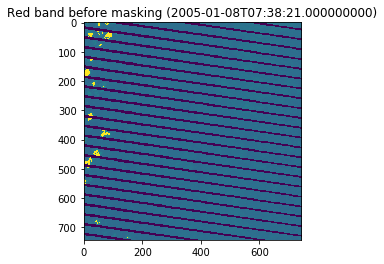

In [10]:
plt.imshow(landsat_dataset.isel(time=0).red)
plt.title("Red band before masking ({})".format(str(landsat_dataset.time.values[0])))
plt.show()

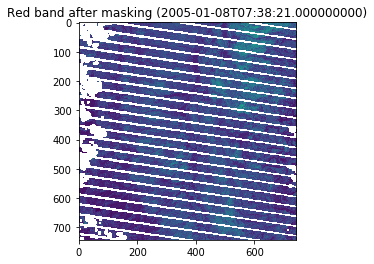

In [11]:
cleaned_landsat_dataset = landsat_dataset.where(clean_mask)
plt.imshow(cleaned_landsat_dataset.isel(time=0).red)
plt.title("Red band after masking ({})".format(str(landsat_dataset.time.values[0])))
plt.show()

## <a id='calculate'>Calculate NDVI</a>

In [12]:
from utils.data_cube_utilities.dc_ndvi import NDVI
ndvi_data_arr = NDVI(cleaned_landsat_dataset)
ndvi = ndvi_data_arr.to_dataset(name='ndvi')

### Chose an acquisition date for plotting a map of NDVI

In [13]:
acquisition_dates = np.array([pd.to_datetime(str(time)).strftime('%Y-%m-%d') for time in cleaned_landsat_dataset.time.values])
print(acquisition_dates)

['2005-01-08' '2005-01-24' '2005-02-25' '2005-03-13' '2005-03-29'
 '2005-04-14' '2005-05-16' '2005-06-01' '2005-06-17' '2005-07-03'
 '2005-08-04' '2005-09-05' '2005-09-21' '2005-10-07']


In [14]:
acquisition = '2005-01-08'
acquisition_index = np.argmax(acquisition_dates == acquisition)

## <a id='true_false_maps'>Examine true and false color maps</a>

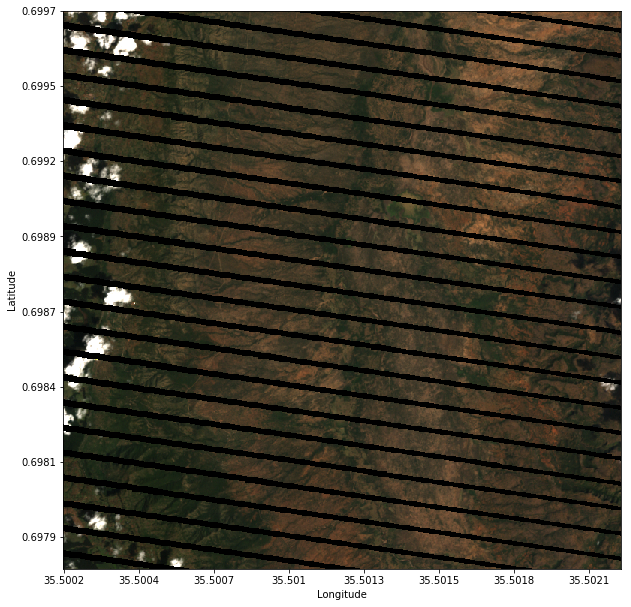

In [15]:
#True color plot
from dc_notebook_utilities import rgb
rgb(landsat_dataset, at_index=acquisition_index, bands=['red', 'green', 'blue'])

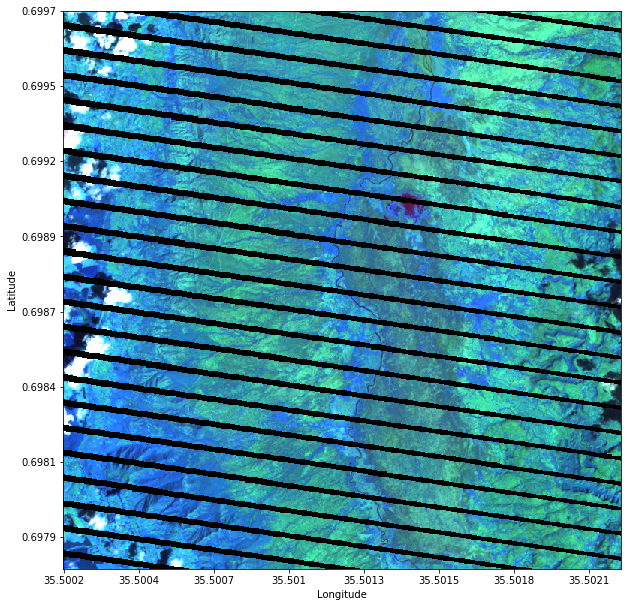

In [16]:
#False color plot
rgb(landsat_dataset, at_index=acquisition_index, bands=['green', 'swir1', 'nir'])

## <a id="plot_maps">Plot NDVI with Gradients</a>

In [17]:
from utils.data_cube_utilities.dc_display_map import display_map
ndvi_plotting_data = ndvi.isel(time=acquisition_index)

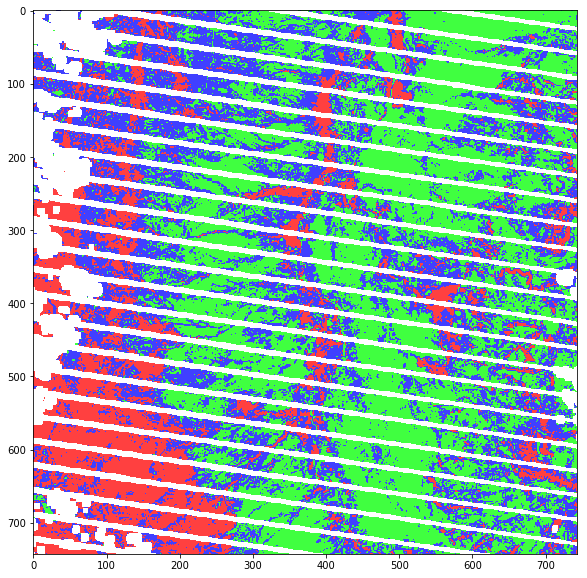

In [18]:
from matplotlib.colors import LinearSegmentedColormap
th = [0.62, 0.95] # Color thresholds
cdict = {'red':   [(0.0, 0.0, 0.0),
                   ((th[0]+th[1])/2, 0.0, 1.0),
                   (th[1], 1.0, 1.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  1.0, 1.0),
                   (th[0], 1.0, 0.0),
                   ((th[0]+th[1])/2, 0.0, 0.0),
                   (1.0, 0.0, 0.0)],
         'blue':  [(0.0,  0.0, 0.0),
                   (th[0], 0.0, 1.0),
                   ((th[0]+th[1])/2, 1.0, 0.0),
                   (th[1], 0.0, 0.0),
                   (1.0, 0.0, 0.0)],
        'alpha': [(0.0, 0.75, 0.75),
                  (1.0, 0.75, 0.75)]}
cmap = LinearSegmentedColormap('my_cmap', cdict)
plt.figure(figsize=(10,10))
plt.imshow(ndvi_plotting_data.ndvi.values, cmap=cmap)

## <a id="time_series_analysis">Plot NDVI statistics over time</a>

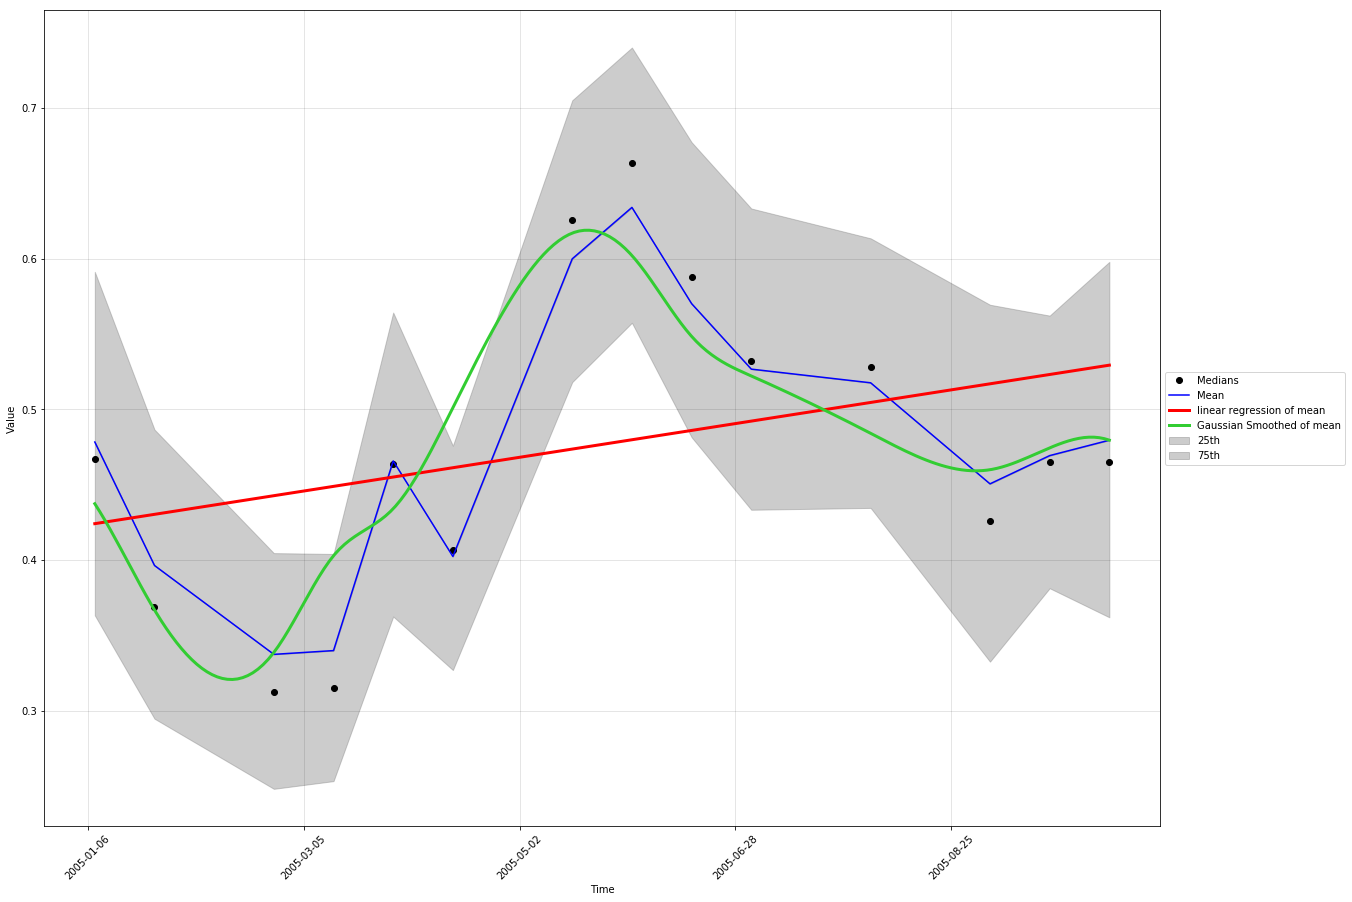

In [19]:
import utils.data_cube_utilities.plotter_utils as plotter
plotter.plot_band(cleaned_landsat_dataset, ndvi_data_arr)

# <a id="mosaic">Examine cleaned, mosaic data</a>

## <a id="retrieve_data_mosaic">Retrieve the data from the datacube</a>

In [20]:
start_date   = min_date
end_date     = max_date
time_extents = (start_date, end_date)
landsat_dataset = dc.load(lat = (min_lat_small, max_lat_small),
                          lon = (min_lon_small, max_lon_small),
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'nir', 'pixel_qa']) 

## <a id="obtain_clean_mask_mosaic">Obtain the clean mask</a>

In [21]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
#Get the clean mask for the LANDSAT satellite platform
clean_mask = landsat_qa_clean_mask(landsat_dataset, platform)

## <a id="clean_mask_mosaic">Filter out clouds and scan lines, and create a mosaic</a>

In [22]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic 
cleaned_landsat_dataset_mosaic = \
    create_mosaic(landsat_dataset, reverse_time=False, clean_mask=clean_mask)

## <a id="baseline">Select a Target Date and Specify a Baseline For Comparison</a>

In [23]:
#get a list of available image aquisition dates
acquisitions_list = np.array(api.list_acquisition_dates(product, longitude=(min_lon, max_lon), latitude=(min_lat, max_lat), time = time_extents))
print("There are {} acquisitions to choose from:".format(len(acquisitions_list)))
for index, acquisition in enumerate(acquisitions_list):
    print(index, acquisition)

There are 173 acquisitions to choose from:
0 2005-01-08 07:38:21
1 2005-01-24 07:38:21
2 2005-02-25 07:38:37
3 2005-03-13 07:38:40
4 2005-03-29 07:38:38
5 2005-04-14 07:38:32
6 2005-05-16 07:38:34
7 2005-06-01 07:38:31
8 2005-06-17 07:38:24
9 2005-07-03 07:38:22
10 2005-08-04 07:38:21
11 2005-09-05 07:38:07
12 2005-09-21 07:38:02
13 2005-10-07 07:37:57
14 2006-01-11 07:38:48
15 2006-01-27 07:38:56
16 2006-02-12 07:39:01
17 2006-02-28 07:39:03
18 2006-04-01 07:39:02
19 2006-05-03 07:39:01
20 2006-05-19 07:39:02
21 2006-06-04 07:39:00
22 2006-10-10 07:38:21
23 2006-11-11 07:38:51
24 2006-12-13 07:39:07
25 2007-02-15 07:39:23
26 2007-03-03 07:39:27
27 2007-03-19 07:39:29
28 2007-04-04 07:39:29
29 2007-04-20 07:39:27
30 2007-05-06 07:39:23
31 2007-05-22 07:39:16
32 2007-06-07 07:39:13
33 2007-07-09 07:39:11
34 2007-08-10 07:39:02
35 2007-08-26 07:38:55
36 2007-09-27 07:38:43
37 2007-10-13 07:38:43
38 2007-10-29 07:38:55
39 2007-11-14 07:39:04
40 2007-11-30 07:39:11
41 2007-12-16 07:39:16
4

In [24]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic, create_median_mosaic, \
                                                create_max_ndvi_mosaic, create_min_ndvi_mosaic

# Select a scene to check for anomalies (one of the acquisition dates shown above).
acquisition_index = 145 # Check for anomalies in the middle of 2015.
scene_sel_datetime = acquisitions_list[acquisition_index]
print("Date selected to check for anomalies: ", scene_sel_datetime)

# Select scenes to form a baseline.
baseline_date_indices = list(range(0,78)) # Use 2005-2010 as the baseline
baseline_datetimes = acquisitions_list[baseline_date_indices]
print("First and last dates selected for baseline: ", baseline_datetimes[[0,-1]])

#Create a dictionary of the different mosaic method options
mosaic_methods = {'Most Recent':create_mosaic, 'Least Recent':create_mosaic,'Median':create_median_mosaic,
                  'Max NDVI':create_max_ndvi_mosaic, 'Min NDVI':create_min_ndvi_mosaic}

# Select a mosaic method for the baseline 
# (One of ['Most Recent','Least Recent','Median','Max NDVI','Min NDVI']).
mosaic_method_label = 'Max NDVI'
mosaic_method = mosaic_methods[mosaic_method_label]
print("Selected mosaic method: ", mosaic_method_label)

# Select a percentage threshold for anomalies.
threshold_percent = 0.05
print("Threshold percentage selected for anomalies: {}%".format(threshold_percent*100))

Date selected to check for anomalies:  2015-07-15 07:48:42
First and last dates selected for baseline:  [datetime.datetime(2005, 1, 8, 7, 38, 21)
 datetime.datetime(2010, 10, 5, 7, 41, 13)]
Selected mosaic method:  Max NDVI
Threshold percentage selected for anomalies: 5.0%


In [25]:
import datetime
#Initialize baseline mosaic for comparison
baseline_mosaic = None

#need to reverse the direction of the mosaicing over time if "Most Recent" selected
reverse_time = True if mosaic_method_label == 'Most Recent' else False
for index in range(len(baseline_datetimes)):
    data = api.get_dataset_by_extent(product, latitude=(min_lat_small, max_lat_small), longitude=(min_lon_small, max_lon_small), 
                                    time=(baseline_datetimes[index],(baseline_datetimes[index+1] if index != len(baseline_datetimes)-1 else baseline_datetimes[index]+datetime.timedelta(seconds=1))),
                                    measurements=['red', 'nir', 'pixel_qa'])
    clean_mask = landsat_qa_clean_mask(data, platform)
    baseline_mosaic = mosaic_method(data, intermediate_product=baseline_mosaic, reverse_time=reverse_time, clean_mask=clean_mask)

## <a id="compare">Calulate the NDVI for the Baseline and Target Scene</a>

In [26]:
import sys #required for epsilon (in case the baseline is zero)

#Calculate the NDVI baseline values
from utils.data_cube_utilities.dc_ndvi import NDVI
ndvi_baseline = NDVI(baseline_mosaic)

#Calculate the NDVI values in the target scene
ndvi_scene = NDVI(cleaned_landsat_dataset_mosaic)

#Determine the percentage change
percentage_change = abs((ndvi_baseline - ndvi_scene) / (ndvi_baseline+sys.float_info.epsilon))

## <a id="plot">Plotting the NDVI Anomalies</a>

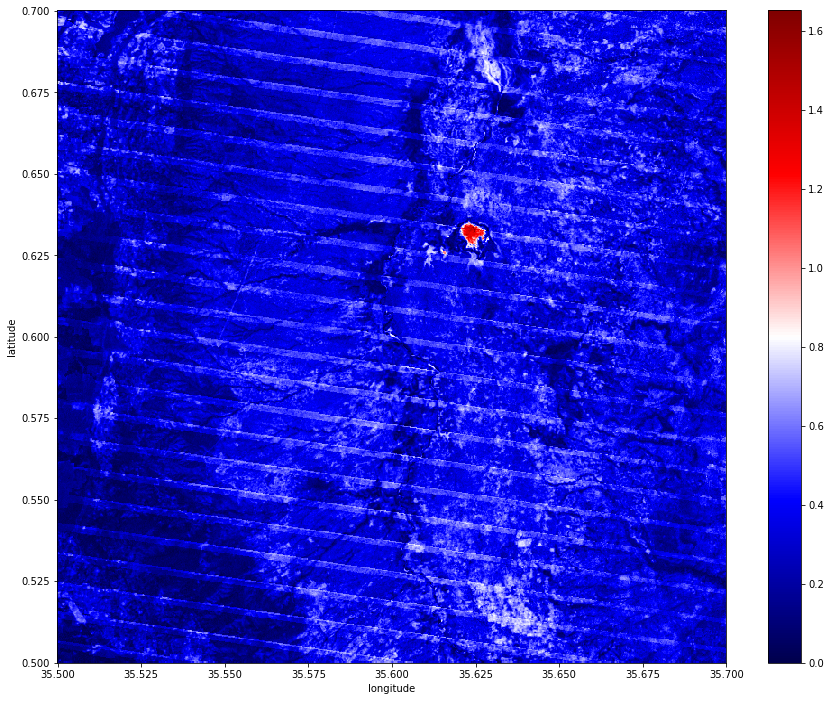

In [27]:
import matplotlib.pyplot as plt

# Set plot size
plt.figure(figsize = (15,12))

# Plot the raw percent changes
percentage_change.plot(cmap='seismic')

If you used the original values for everything up to this point, you can clearly see an NDVI anomaly. This indicates that there was a measurable difference in the amount of photosynthetic plants in the area compared to the standard defined by the baseline composite image.

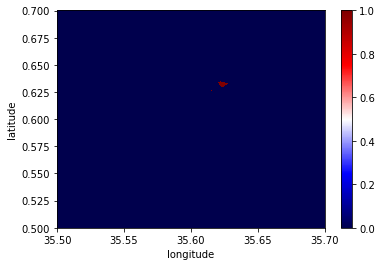

In [28]:
# Use a cutoff value
anom = percentage_change > 1 
anom.plot(cmap='seismic')

In [29]:
# Examine the area again
display_map(latitude = (.5, .7),longitude = (35.5, 35.7))

The anomaly we detected was Lake Kamnarok in Kenya. Lake Kamnarok, named after all the <i>Narok</i> plants in it, dried up in 2015. When it did, a significant number of the plants inside and around it died.  Without any prior knowledge about the lake, we were able to determine that there was a significant change in the plant life there using satellite imagery.